In [1]:
## imports 
import os, sys
import gymnasium as gym
import time
import numpy as np
import text_flappy_bird_gym
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

np.random.seed(1)

## Utils 

In [2]:
def play_game_policy(policy):    
    # initiate environment
    env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
    obs, _ = env.reset()

    # iterate
    while True:
        print("obs", obs)
        
        if policy is not None: 
            action = policy[obs]
        else: # random policy
            action = env.action_space.sample()
            
        # Appy action and return new observation of the environment
        obs, reward, done, _, info = env.step(action)

        # Render the game
        os.system("clear")
        sys.stdout.write(env.render())
        time.sleep(0.2) # FPS

        # If player is dead break
        if done:
            break

    env.close()

play_game_policy(None) # Random policy

obs (13, 0)
Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                    ]
[      @             ]
[                    ]
[                    ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=12,dy=-1)
obs (12, -1)
Text Flappy Bird!
Score: 0
----------------------
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                    ]
[                    ]
[      @             ]
[                    ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=11,dy=0)
obs (11, 0)
Text Flappy Bird!
Sc

## Monte carlo Q learning agent

In [3]:
class QLearningAgent():
    def __init__(self, num_actions, alpha=0.1, gamma=0.9, eps_start=0.1, eps_decay=.99999, eps_min=0.05):

        self.alpha = alpha
        self.gamma = gamma
        self.eps_start = eps_start
        self.eps_decay = eps_decay
        self.eps_min = eps_min


        self.num_actions = num_actions
        self.cumulative_rewards = []
        self.scores =[]
        
    def generate_episode_from_Q(self, env, Q, epsilon, nA):
        episode = []
        state, info = env.reset()
        while True:
            action = np.random.choice(np.arange(nA), p=self.get_probs(Q[state], epsilon, nA)) \
                                        if state in Q else env.action_space.sample()
            next_state, reward, done, false, info = env.step(action)
            episode.append((state, action, reward, info))
            state = next_state
            if done:
                break
        return episode

    def get_probs(self, Q_s, epsilon, nA):
        policy_s = epsilon / nA * np.ones(nA)
        best_a = np.argmax(Q_s)
        policy_s[best_a] = 1-epsilon+(epsilon/nA)
        return policy_s

    def update_Q(self, env, episode, Q, alpha, gamma):
        states, actions, rewards, info = zip(*episode)
        # prepare for discounting
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        for i, state in enumerate(states):
            old_Q = Q[state][actions[i]]
            Q[state][actions[i]] =old_Q + alpha * (sum(rewards[i:] * discounts[:-(i+1)]) - old_Q)
        return Q
    
    ## train the agent
    def mc_control(self, env):
        nA = env.action_space.n
        # initialize empty dictionary of arrays
        Q = defaultdict(lambda: np.zeros(nA))
        
        epsilon = self.eps_start
        # loop over episodes
        for i_episode in range(1, self.num_actions+1):
            # monitor progress
            if i_episode % 1000 == 0:
                print("\rEpisode {}/{}.".format(i_episode, self.num_actions), end="")
                sys.stdout.flush()
            # set the value of epsilon
            epsilon = max(epsilon*self.eps_decay, self.eps_min)
            # generate an episode by following epsilon-greedy policy
            episode = self.generate_episode_from_Q(env, Q, epsilon, nA)  ## liste etat action reward    
            # update the action-value function estimate using the episode
            Q = self.update_Q(env, episode, Q, self.alpha, self.gamma)     
            self.cumulative_rewards.append(sum([x[2] for x in episode]))
            self.scores.append(episode[-1][3]['score'])
        # determine the policy corresponding to the final action-value function estimate
        policy = dict((k,np.argmax(v)) for k, v in Q.items())
        return policy, Q


#### Train first model

In [4]:
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
agent_MC = QLearningAgent(num_actions=10000, alpha=0.1, gamma=0.9, eps_start=0.1, eps_decay=.99999, eps_min=0.05)
policy_MC, Q_MC = agent_MC.mc_control(env=env)

Episode 10000/10000.

### Plot evolution of cumulative rewards and scores as a function of number of episodes

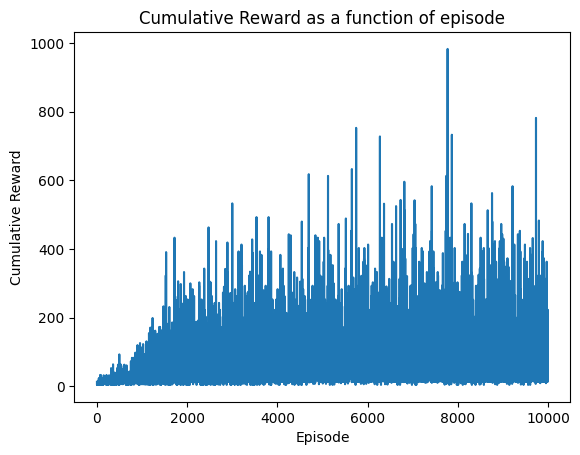

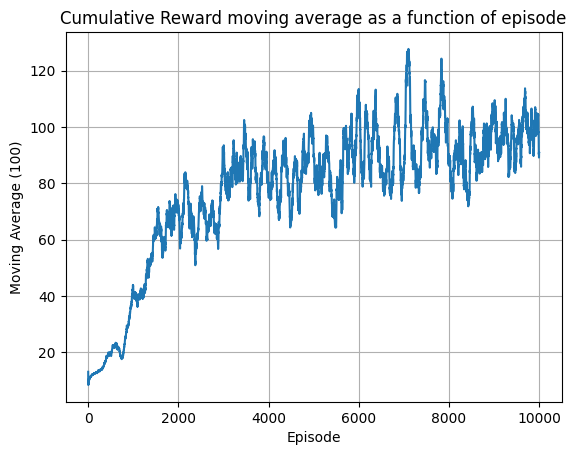

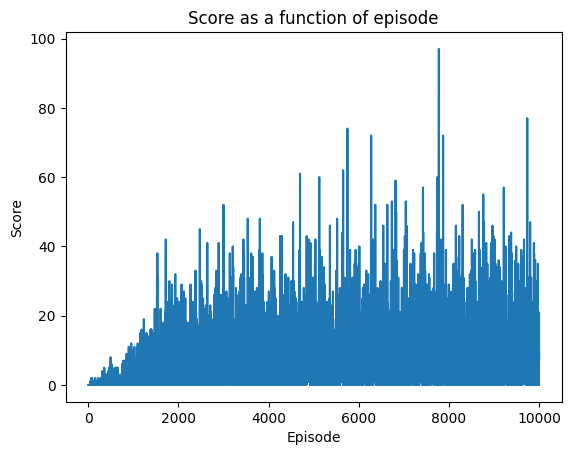

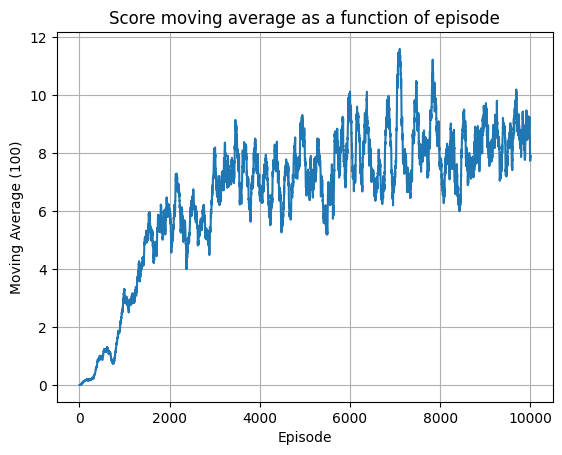

In [5]:
## plot 
plt.plot(agent_MC.cumulative_rewards)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward as a function of episode')
plt.show()

## plot moving average
window = 100
cumulative_rewards = agent_MC.cumulative_rewards
moving_avg = [np.mean(cumulative_rewards[i-window:i]) if i > window 
              else np.mean(cumulative_rewards[:i]) for i in range(1, len(cumulative_rewards))]
plt.plot(moving_avg)
plt.xlabel('Episode')
plt.ylabel('Moving Average (100)')
plt.title('Cumulative Reward moving average as a function of episode')
plt.grid()
plt.show()

## plot scores
plt.plot(agent_MC.scores)
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('Score as a function of episode')
plt.show()

## plot scores moving average
window = 100
scores = agent_MC.scores
moving_avg = [np.mean(scores[i-window:i]) if i > window 
              else np.mean(scores[:i]) for i in range(1, len(scores))]
plt.plot(moving_avg)
plt.xlabel('Episode')
plt.ylabel('Moving Average (100)')
plt.title('Score moving average as a function of episode')
plt.grid()
plt.show()

### plot state values

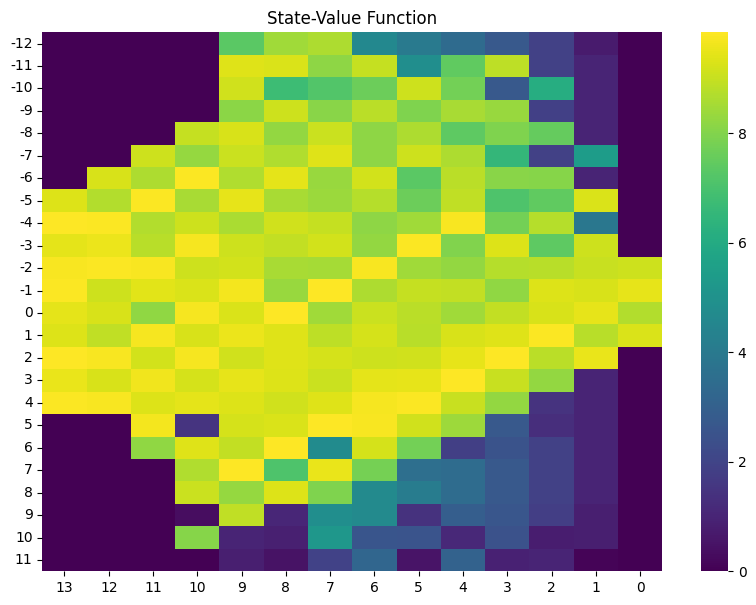

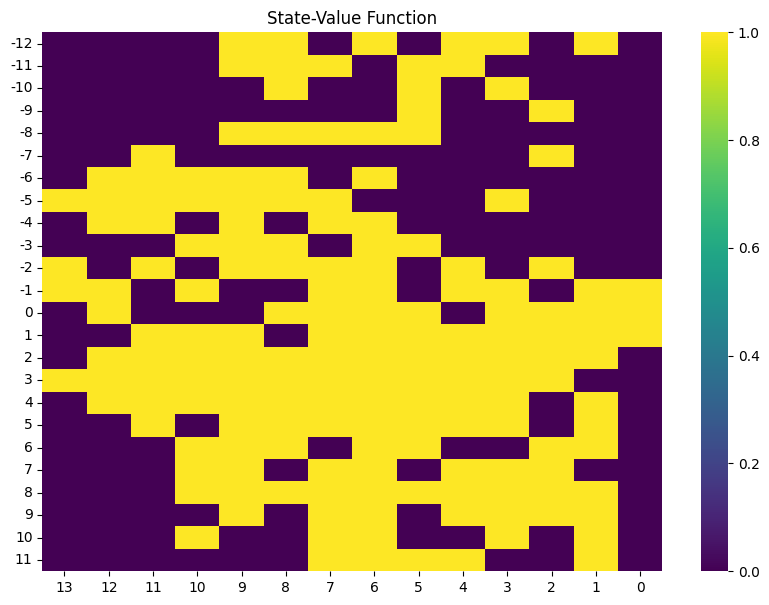

In [6]:
dic_state_values = {k: np.max(v) for k, v in Q_MC.items()}
x_ranges = np.unique([x[0] for x in Q_MC.keys()])
y_ranges = np.unique([x[1] for x in Q_MC.keys()])

state_values = np.zeros((len(x_ranges), len(y_ranges)))
df = pd.DataFrame(state_values, index=x_ranges, columns=y_ranges).sort_index(ascending=False).T.sort_index(ascending=True)
for k, v in dic_state_values.items():
    df.loc[k[1], k[0]] = v

# heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(df, cmap='viridis')
plt.title('State-Value Function')
plt.show()

x_ranges = np.unique([x[0] for x in Q_MC.keys()])
y_ranges = np.unique([x[1] for x in Q_MC.keys()])

actions = np.zeros((len(x_ranges), len(y_ranges)))
df = pd.DataFrame(actions, index=x_ranges, columns=y_ranges).sort_index(ascending=False).T.sort_index(ascending=True)
for k, v in policy_MC.items():
    df.loc[k[1], k[0]] = v

# heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(df, cmap='viridis')
plt.title('State-Value Function')
plt.show()


In [7]:
# play_game_policy(policy_MC) # Q-learning policy

### compare with different hyperparameters

Episode 10000/10000.alpha=0.01 done
Episode 10000/10000.alpha=0.05 done
Episode 10000/10000.alpha=0.1 done
Episode 10000/10000.alpha=0.3 done
Episode 10000/10000.alpha=0.5 done


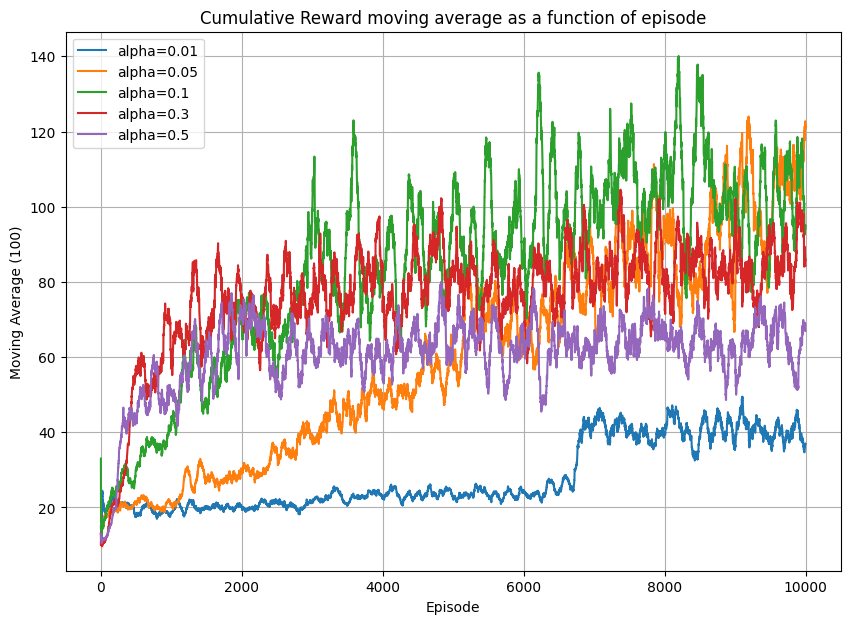

In [8]:
# lets vary alpha
dict_policies = {}
for alpha in [0.01, 0.05, 0.1, 0.3, 0.5]:
    env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
    agent = QLearningAgent(num_actions=10000, alpha=alpha, gamma=0.9, eps_start=0.1, eps_decay=.99999, eps_min=0.05)
    policy, Q = agent.mc_control(env=env)
    dict_policies[alpha] = {'policy': policy, 'Q': Q, "cumulative_rewards": agent.cumulative_rewards, "cumulative_scores": agent.scores}
    print(f'alpha={alpha} done')
## plot moving average rewards
plt.figure(figsize=(10, 7))
for alpha, data in dict_policies.items():
    window = 100
    cumulative_rewards = data["cumulative_rewards"]
    moving_avg = [np.mean(cumulative_rewards[i-window:i]) if i > window 
                  else np.mean(cumulative_rewards[:i]) for i in range(1, len(cumulative_rewards))]
    plt.plot(moving_avg, label=f'alpha={alpha}')
plt.xlabel('Episode')
plt.ylabel('Moving Average (100)')
plt.title('Cumulative Reward moving average as a function of episode')
plt.grid()
plt.legend()
plt.show()


Episode 10000/10000.eps_start=0.1 done
Episode 10000/10000.eps_start=0.3 done
Episode 10000/10000.eps_start=0.7 done
Episode 10000/10000.eps_start=1 done


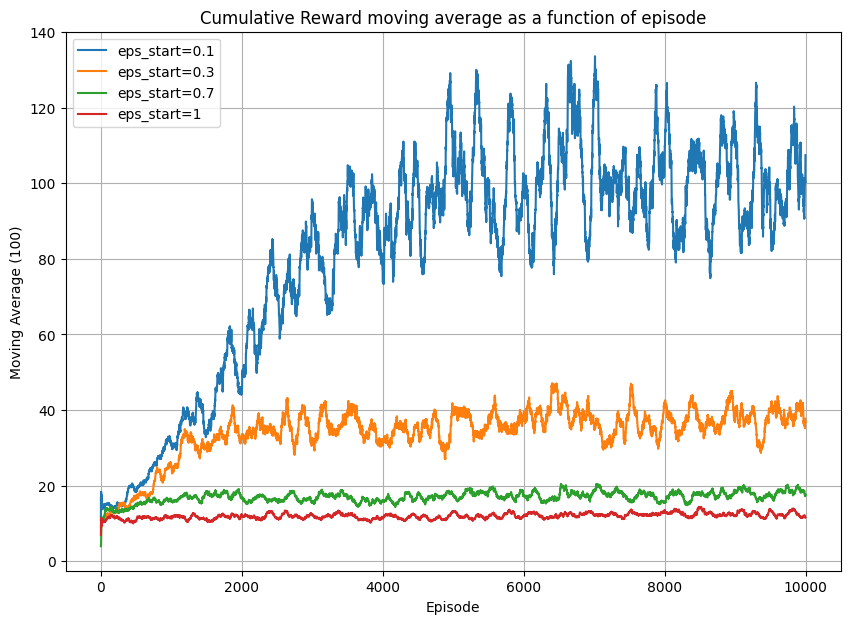

In [9]:
# lets vary eps_start
dict_policies = {}
for eps_start in [0.1, 0.3, 0.7, 1]:
    env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
    agent = QLearningAgent(num_actions=10000, alpha=0.1, gamma=0.9, eps_start=eps_start, eps_decay=.99999, eps_min=0.05)
    policy, Q = agent.mc_control(env=env)
    dict_policies[eps_start] = {'policy': policy, 'Q': Q, "cumulative_rewards": agent.cumulative_rewards, "cumulative_scores": agent.scores}
    print(f'eps_start={eps_start} done')
## plot moving average rewards
plt.figure(figsize=(10, 7))
for eps_start, data in dict_policies.items():
    window = 100
    cumulative_rewards = data["cumulative_rewards"]
    moving_avg = [np.mean(cumulative_rewards[i-window:i]) if i > window 
                  else np.mean(cumulative_rewards[:i]) for i in range(1, len(cumulative_rewards))]
    plt.plot(moving_avg, label=f'eps_start={eps_start}')
plt.xlabel('Episode')
plt.ylabel('Moving Average (100)')
plt.title('Cumulative Reward moving average as a function of episode')
plt.grid()
plt.legend()
plt.show()


Episode 10000/10000.gamma=0.8 done
Episode 10000/10000.gamma=0.9 done
Episode 10000/10000.gamma=0.95 done
Episode 10000/10000.gamma=1.0 done


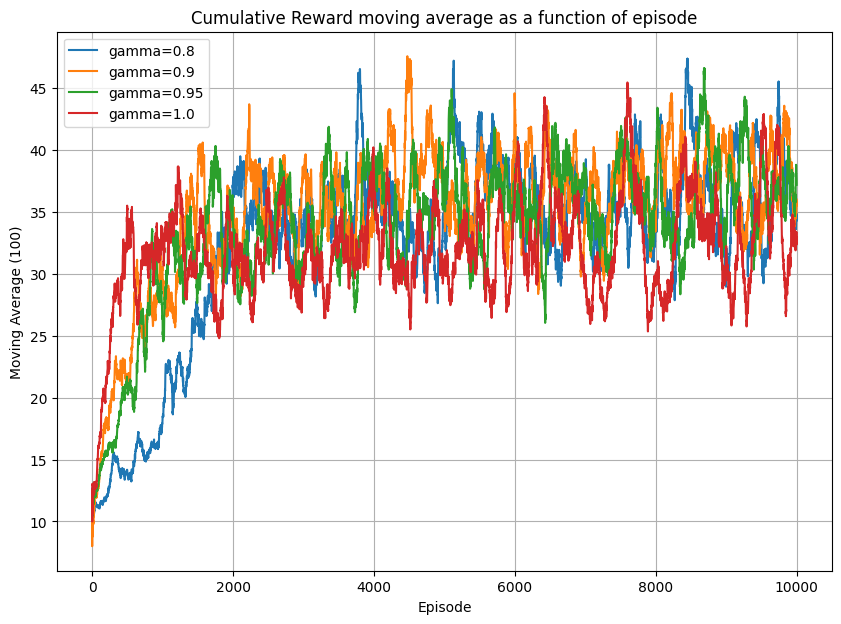

In [10]:
# lets vary gamma
dict_policies = {}
for gamma in [0.8, 0.9, 0.95, 1.0]:
    env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
    agent = QLearningAgent(num_actions=10000, alpha=0.1, gamma=gamma, eps_start=0.3, eps_decay=.99999, eps_min=0.05)
    policy, Q = agent.mc_control(env=env)
    dict_policies[gamma] = {'policy': policy, 'Q': Q, "cumulative_rewards": agent.cumulative_rewards, "cumulative_scores": agent.scores}
    print(f'gamma={gamma} done')
## plot moving average rewards
plt.figure(figsize=(10, 7))
for gamma, data in dict_policies.items():
    window = 100
    cumulative_rewards = data["cumulative_rewards"]
    moving_avg = [np.mean(cumulative_rewards[i-window:i]) if i > window 
                  else np.mean(cumulative_rewards[:i]) for i in range(1, len(cumulative_rewards))]
    plt.plot(moving_avg, label=f'gamma={gamma}')
plt.xlabel('Episode')
plt.ylabel('Moving Average (100)')
plt.title('Cumulative Reward moving average as a function of episode')
plt.grid()
plt.legend()
plt.show()


## SARSA lambda

In [11]:
class SarsaLambdaAgent:
    def __init__(self, env, alpha=0.01, gamma=0.9, lambda_=0.9, eps=0.1):
        self.env = env
        self.number_actions = env.action_space.n
        self.number_x = env.observation_space[0].n
        self.number_y = env.observation_space[1].n
        
        self.alpha = alpha
        self.gamma = gamma
        self.lambda_ = lambda_
        self.eps = eps
        
        self.w = np.zeros(self.number_x * self.number_y * self.number_actions) # Weights
        
        # For tracking rewards
        self.cumulative_rewards = []
        self.scores = []
        
    
    def get_q_value(self, state, action):
        return np.sum(self.w[self.get_active_features(state, action)])
    
    def get_probabilities(self, state, epsilon):
        probabilities = np.ones(self.number_actions) * epsilon / self.number_actions
        probabilities[np.argmax(np.array([self.get_q_value(state, a) for a in range(self.number_actions)]))] += (1.0 - epsilon)
        return probabilities
    
    def get_active_features(self, state, action):
        return [action * (self.number_x + self.number_y) + state[0], action * (self.number_x + self.number_y) + self.number_x + state[1] + 13]
    
    def generate_episode(self):
        episode = []
        cumulative_reward = 0
        
        state, _ = self.env.reset()
        action = np.random.choice(np.arange(self.number_actions), p=self.get_probabilities(state, self.eps))
        
        temp = np.zeros(self.number_x * self.number_y * self.number_actions)
        
        while True:
            next_state, reward, done, _, info = self.env.step(action)
            cumulative_reward += reward
            episode.append((state, action, reward, info))
            
            d = reward
            active_feats = self.get_active_features(state, action)
            for i in active_feats:
                d -= self.w[i]
                temp[i] += 1.0
            
            if done:
                self.w += self.alpha * d * temp
                break
            
            temp *= (self.gamma * self.lambda_)
            
            next_action = np.random.choice(np.arange(self.number_actions), p=self.get_probabilities(next_state, self.eps))
            
            next_active_feats = self.get_active_features(next_state, next_action)
            for i in next_active_feats:
                d += self.gamma * self.w[i]
            
            self.w += self.alpha * d * temp
            temp = temp * self.gamma * self.lambda_

            state = next_state
            action = next_action
        
        self.cumulative_rewards.append(cumulative_reward)
        self.scores.append(episode[-1][3]['score'])
        return episode
    
    def train(self, num_episodes):
        for i in tqdm(range(1, num_episodes + 1)):
            self.generate_episode()
    
    def get_greedy_action(self, state):
        return np.argmax(np.array([self.get_q_value(state, a) for a in range(self.number_actions)]))

    def get_policy_and_Q_matrix(self):
        Q = defaultdict(lambda: np.zeros(self.number_actions))
        for x in range(self.number_x):
            for y in range(self.number_y):
                for a in range(self.number_actions):
                    Q[(x, y)][a] = self.get_q_value((x, y), a)

        policy = defaultdict(lambda : 0)
        for x in range(self.number_x):
            for y in range(self.number_y):
                policy[(x, y)] = self.get_greedy_action((x, y))
        return policy, Q

In [ ]:
agent_sarsa = SarsaLambdaAgent(env, alpha=0.5, gamma=0.9, lambda_=0.9, eps=0.1)
agent_sarsa.train(10000)
policy_sarsa, Q_sarsa = agent_sarsa.get_policy_and_Q_matrix()

### Plot evolution of cumulative rewards and scores as a function of number of episodes

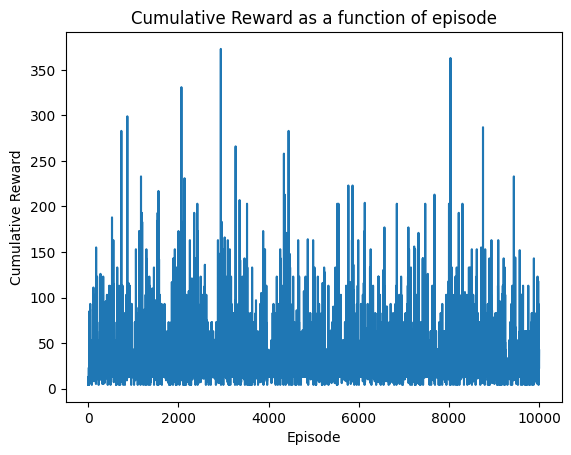

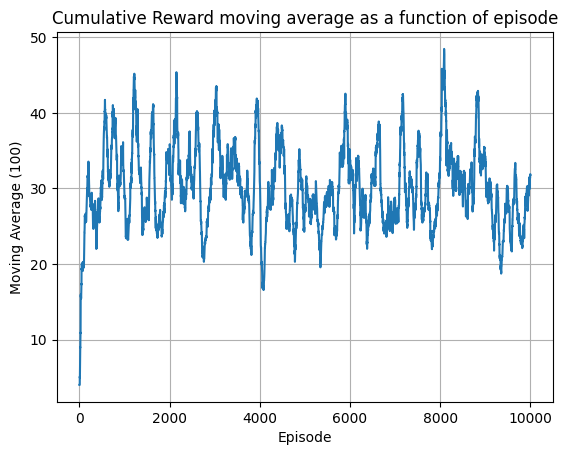

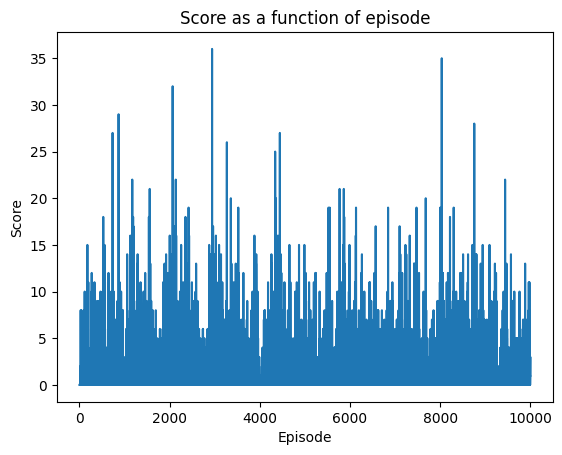

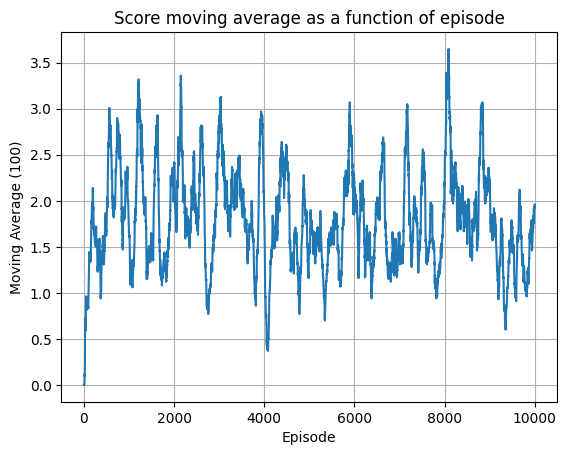

In [15]:
## plot 
plt.plot(agent_sarsa.cumulative_rewards)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward as a function of episode')
plt.show()

## plot moving average
window = 100
cumulative_rewards = agent_sarsa.cumulative_rewards
moving_avg = [np.mean(cumulative_rewards[i-window:i]) if i > window 
              else np.mean(cumulative_rewards[:i]) for i in range(1, len(cumulative_rewards))]
plt.plot(moving_avg)
plt.xlabel('Episode')
plt.ylabel('Moving Average (100)')
plt.title('Cumulative Reward moving average as a function of episode')
plt.grid()
plt.show()

## plot scores
plt.plot(agent_sarsa.scores)
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('Score as a function of episode')
plt.show()

## plot scores moving average
window = 100
scores = agent_sarsa.scores
moving_avg = [np.mean(scores[i-window:i]) if i > window 
              else np.mean(scores[:i]) for i in range(1, len(scores))]
plt.plot(moving_avg)
plt.xlabel('Episode')
plt.ylabel('Moving Average (100)')
plt.title('Score moving average as a function of episode')
plt.grid()
plt.show()

### plot state values

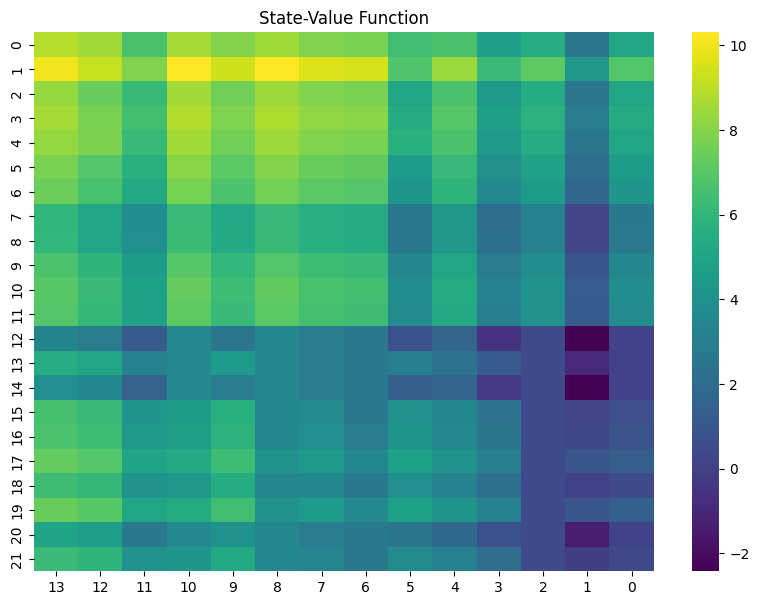

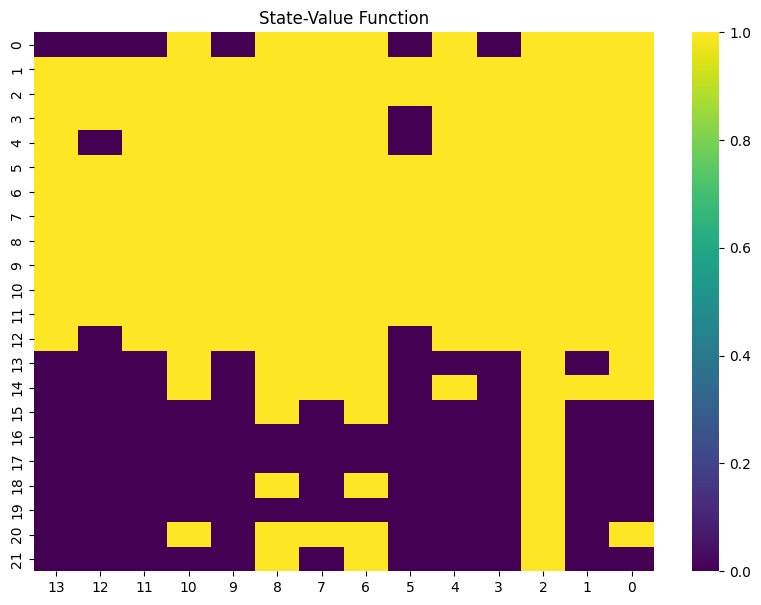

In [16]:
dic_state_values = {k: np.max(v) for k, v in Q_sarsa.items()}
x_ranges = np.unique([x[0] for x in Q_sarsa.keys()])
y_ranges = np.unique([x[1] for x in Q_sarsa.keys()])

state_values = np.zeros((len(x_ranges), len(y_ranges)))
df = pd.DataFrame(state_values, index=x_ranges, columns=y_ranges).sort_index(ascending=False).T.sort_index(ascending=True)
for k, v in dic_state_values.items():
    df.loc[k[1], k[0]] = v

# heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(df, cmap='viridis')
plt.title('State-Value Function')
plt.show()

x_ranges = np.unique([x[0] for x in Q_sarsa.keys()])
y_ranges = np.unique([x[1] for x in Q_sarsa.keys()])

actions = np.zeros((len(x_ranges), len(y_ranges)))
df = pd.DataFrame(actions, index=x_ranges, columns=y_ranges).sort_index(ascending=False).T.sort_index(ascending=True)
for k, v in policy_sarsa.items():
    df.loc[k[1], k[0]] = v

# heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(df, cmap='viridis')
plt.title('State-Value Function')
plt.show()


In [17]:
# play_game_policy(policy_sarsa) # lambda-sarsa policy

### compare with different hyperparameters

100%|██████████| 10000/10000 [01:17<00:00, 129.28it/s]


alpha=0.01 done


100%|██████████| 10000/10000 [01:24<00:00, 118.52it/s]


alpha=0.05 done


100%|██████████| 10000/10000 [01:30<00:00, 111.10it/s]


alpha=0.1 done


100%|██████████| 10000/10000 [01:01<00:00, 163.78it/s]


alpha=0.3 done


100%|██████████| 10000/10000 [00:42<00:00, 236.00it/s]


alpha=0.5 done


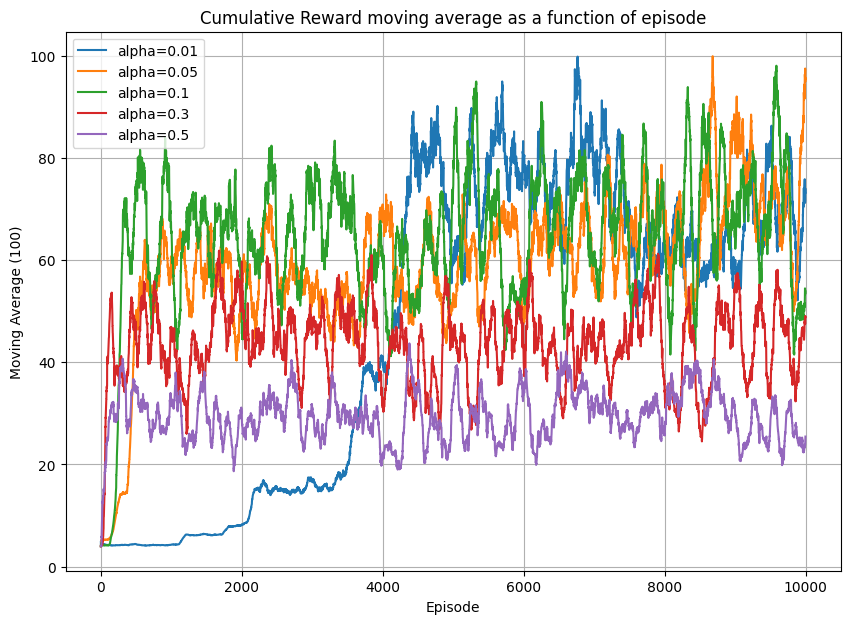

In [19]:
# lets vary alpha
dict_policies = {}
for alpha in [0.01, 0.05, 0.1, 0.3, 0.5]:
    env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
    agent = SarsaLambdaAgent(env, alpha=alpha, gamma=0.9, lambda_=0.9, eps=0.1)
    agent.train(10000)
    policy, Q = agent.get_policy_and_Q_matrix()
    dict_policies[alpha] = {'policy': policy, 'Q': Q, "cumulative_rewards": agent.cumulative_rewards, "cumulative_scores": agent.scores}
    print(f'alpha={alpha} done')
## plot moving average rewards
plt.figure(figsize=(10, 7))
for alpha, data in dict_policies.items():
    window = 100
    cumulative_rewards = data["cumulative_rewards"]
    moving_avg = [np.mean(cumulative_rewards[i-window:i]) if i > window 
                  else np.mean(cumulative_rewards[:i]) for i in range(1, len(cumulative_rewards))]
    plt.plot(moving_avg, label=f'alpha={alpha}')
plt.xlabel('Episode')
plt.ylabel('Moving Average (100)')
plt.title('Cumulative Reward moving average as a function of episode')
plt.grid()
plt.legend()
plt.show()


100%|██████████| 10000/10000 [00:42<00:00, 234.09it/s]


eps_start=0.1 done


100%|██████████| 10000/10000 [00:27<00:00, 362.45it/s]


eps_start=0.3 done


100%|██████████| 10000/10000 [00:19<00:00, 525.28it/s]


eps_start=0.7 done


100%|██████████| 10000/10000 [00:15<00:00, 652.31it/s]


eps_start=1 done


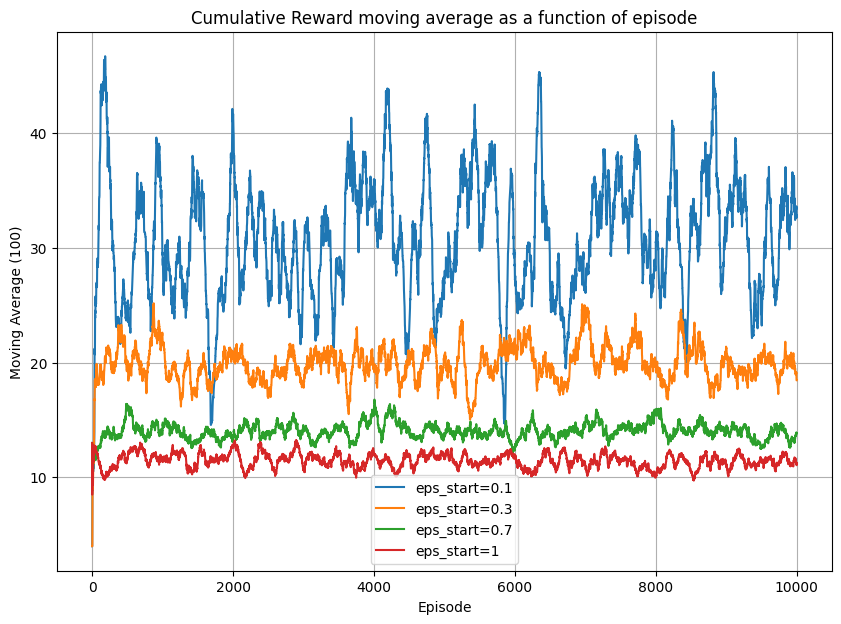

In [20]:
# lets vary eps_start
dict_policies = {}
for eps_start in [0.1, 0.3, 0.7, 1]:
    env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
    agent = SarsaLambdaAgent(env, alpha=0.5, gamma=0.9, lambda_=0.9, eps=eps_start)
    agent.train(10000)
    policy, Q = agent.get_policy_and_Q_matrix()
    dict_policies[eps_start] = {'policy': policy, 'Q': Q, "cumulative_rewards": agent.cumulative_rewards, "cumulative_scores": agent.scores}
    print(f'eps_start={eps_start} done')
## plot moving average rewards
plt.figure(figsize=(10, 7))
for eps_start, data in dict_policies.items():
    window = 100
    cumulative_rewards = data["cumulative_rewards"]
    moving_avg = [np.mean(cumulative_rewards[i-window:i]) if i > window 
                  else np.mean(cumulative_rewards[:i]) for i in range(1, len(cumulative_rewards))]
    plt.plot(moving_avg, label=f'eps_start={eps_start}')
plt.xlabel('Episode')
plt.ylabel('Moving Average (100)')
plt.title('Cumulative Reward moving average as a function of episode')
plt.grid()
plt.legend()
plt.show()


100%|██████████| 10000/10000 [00:41<00:00, 240.14it/s]


gamma=0.8 done


100%|██████████| 10000/10000 [00:53<00:00, 186.52it/s]


gamma=0.9 done


100%|██████████| 10000/10000 [00:42<00:00, 232.79it/s]


gamma=0.95 done


100%|██████████| 10000/10000 [00:37<00:00, 265.02it/s]


gamma=1.0 done


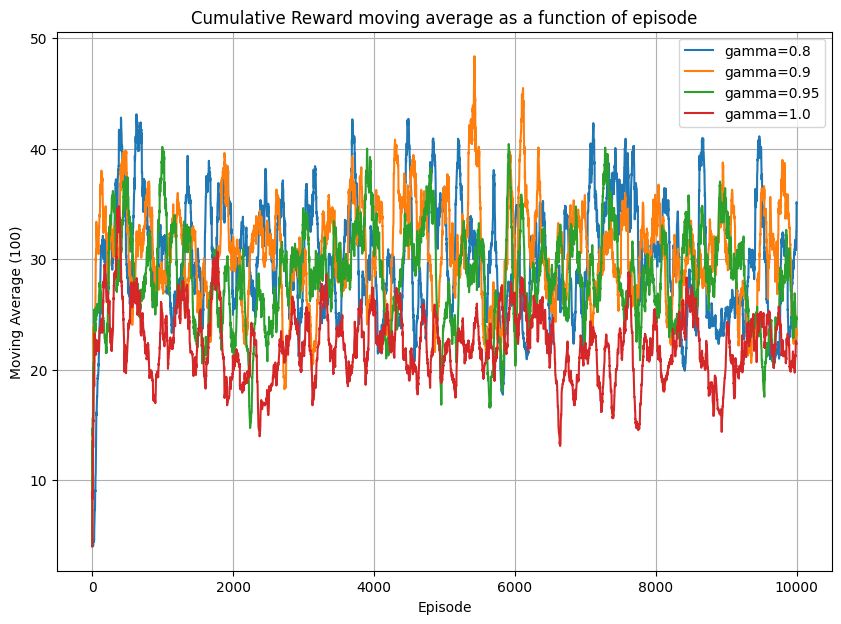

In [21]:
# lets vary gamma
dict_policies = {}
for gamma in [0.8, 0.9, 0.95, 1.0]:
    env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
    agent = SarsaLambdaAgent(env, alpha=0.5, gamma=gamma, lambda_=0.9, eps=0.1)
    agent.train(10000)
    policy, Q = agent.get_policy_and_Q_matrix()
    dict_policies[gamma] = {'policy': policy, 'Q': Q, "cumulative_rewards": agent.cumulative_rewards, "cumulative_scores": agent.scores}
    print(f'gamma={gamma} done')
## plot moving average rewards
plt.figure(figsize=(10, 7))
for gamma, data in dict_policies.items():
    window = 100
    cumulative_rewards = data["cumulative_rewards"]
    moving_avg = [np.mean(cumulative_rewards[i-window:i]) if i > window 
                  else np.mean(cumulative_rewards[:i]) for i in range(1, len(cumulative_rewards))]
    plt.plot(moving_avg, label=f'gamma={gamma}')
plt.xlabel('Episode')
plt.ylabel('Moving Average (100)')
plt.title('Cumulative Reward moving average as a function of episode')
plt.grid()
plt.legend()
plt.show()


100%|██████████| 10000/10000 [00:49<00:00, 200.66it/s]


lambda=0.8 done


100%|██████████| 10000/10000 [00:44<00:00, 226.01it/s]


lambda=0.9 done


100%|██████████| 10000/10000 [00:38<00:00, 259.64it/s]


lambda=0.95 done


100%|██████████| 10000/10000 [00:33<00:00, 300.84it/s]


lambda=1.0 done


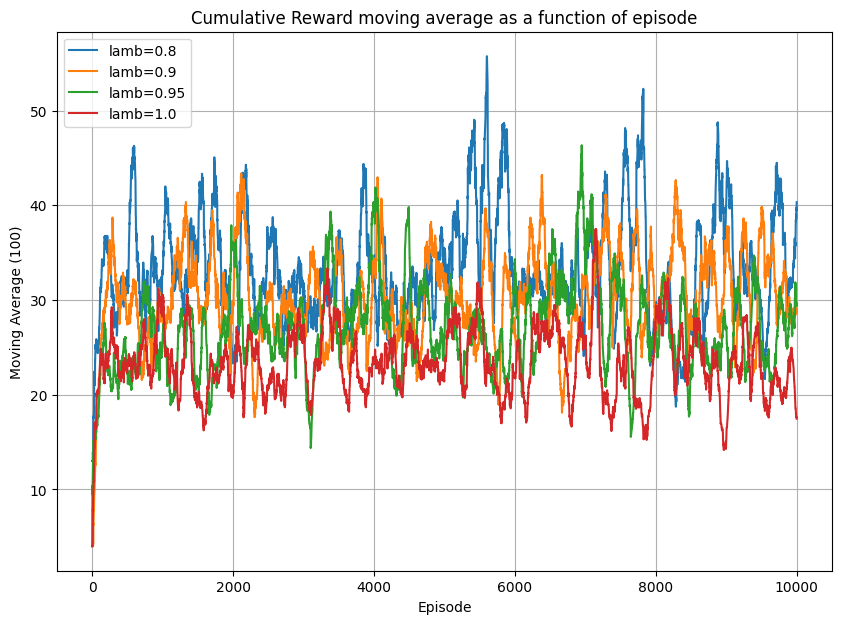

In [22]:
# lets vary lambda
dict_policies = {}
for lamb in [0.8, 0.9, 0.95, 1.0]:
    env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
    agent = SarsaLambdaAgent(env, alpha=0.5, gamma=0.9, lambda_=lamb, eps=0.1)
    agent.train(10000)
    policy, Q = agent.get_policy_and_Q_matrix()
    dict_policies[lamb] = {'policy': policy, 'Q': Q, "cumulative_rewards": agent.cumulative_rewards, "cumulative_scores": agent.scores}
    print(f'lambda={lamb} done')
## plot moving average rewards
plt.figure(figsize=(10, 7))
for lamb, data in dict_policies.items():
    window = 100
    cumulative_rewards = data["cumulative_rewards"]
    moving_avg = [np.mean(cumulative_rewards[i-window:i]) if i > window 
                  else np.mean(cumulative_rewards[:i]) for i in range(1, len(cumulative_rewards))]
    plt.plot(moving_avg, label=f'lamb={lamb}')
plt.xlabel('Episode')
plt.ylabel('Moving Average (100)')
plt.title('Cumulative Reward moving average as a function of episode')
plt.grid()
plt.legend()
plt.show()
